In [36]:
import xarray as xr
from datetime import datetime
from datetime import timedelta
import os
import numpy as np

In [37]:
dataPath = '/glade/scratch/hardt'

start = datetime(2016, 6, 24, 0, 0 ,0)
end = datetime(2016, 6, 26, 0, 0, 0)
fcst_lead = timedelta(minutes=180)
forecast_frequency = timedelta(hours=3)

current = start
modelFiles = []
precipFiles = []

while(current < end):
    
    fcst_time = current + fcst_lead
    
    modelFilePath = dataPath + "/STEP_RT" + str(current.year) + "/cycle/" + str(current.strftime("%Y%m%d%H"))
    model_file = modelFilePath + "/wrfout_d02_" + str(fcst_time.date()) + "_" + str(fcst_time.strftime("%H:%M:%S"))

    if os.path.isfile(model_file):
        modelFiles.append(model_file)
        #print(model_file)
       
    current = current + forecast_frequency
   
DS = xr.open_mfdataset(modelFiles, data_vars=['W', 'QRAIN'], combine='nested', concat_dim='Time')

In [38]:
# Read in W and QRAIN (3D) fields

W_da = DS.W.sel()
QR_da = DS.QRAIN.sel()

# remove the first 104 data points in the west to east direction
# to remove areas over the mountains

W_da = W_da.sel( west_east=slice(105,411))
QR_da = QR_da.sel( west_east=slice(105,411))

# convert to numpy arrays

W_da_numpy = W_da.values
QR_da_numpy = QR_da.values

# data dimensions should be the same for both fields

print(W_da_numpy.shape)
print(QR_da_numpy.shape)

times, lvls, xs, ys = W_da_numpy.shape


(16, 51, 320, 305)
(16, 50, 320, 305)


In [39]:
# get a 2D W array using max in column
# unet want dimensions by # of images, x, y, channels

W_da_max_col = np.zeros( (times,xs,ys,1) )
for time in range(times):
    for x in range(xs):
        for y in range(ys):
            W_da_max_col[time,x,y,0] = np.max(W_da_numpy[time,:,x,y])
W_da_max_col = np.max(W_da_numpy, axis=1)
print(W_da_max_col.shape)

(16, 320, 305)


In [40]:
# get a 2D QRAIN array using max in column

QR_da_max_col = np.zeros( (times,xs,ys, 1) )
for time in range(times):
    for x in range(xs):
        for y in range(ys):
            QR_da_max_col[time,x,y,0] = np.max(QR_da_numpy[time,:,x,y])
QR_da_max_col = np.max(QR_da_numpy, axis=1)
print(QR_da_max_col.shape)

(16, 320, 305)


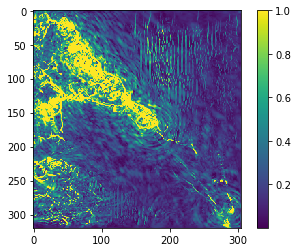

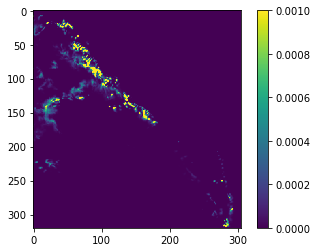

In [41]:
import matplotlib.pyplot as plt

plt.imshow(W_da_max_col[15,:,:])
plt.colorbar()
plt.clim(np.min(W_da_max_col[15,:,:]),1)
plt.show()

plt.imshow(QR_da_max_col[15,:,:])
plt.colorbar()
plt.clim(np.min(QR_da_max_col[15,:,:]),.001)
plt.show()


In [42]:
import tensorflow as tf
from tensorflow import keras


In [43]:
from tf_unet import unet, util, image_util

data = image_util.SimpleDataProvider(W_da_max_col, QR_da_max_col)

In [44]:
print(data.data[15,0,0])

0.22267614


In [45]:
print(data.label[15,0,0])

4.8706532e-14


In [46]:
net = unet.Unet(channels=data.channels, n_class=data.n_class, layers=3, features_root=16)

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

In [13]:
trainer = unet.Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))

NameError: name 'net' is not defined

In [22]:
output_path = '/glade/scratch/hardt/testing'
path = trainer.train(data, output_path,
                     training_iters=32,
                     epochs=5,
                     dropout=0.75,# probability to keep units
                     display_step=2)

path = trainer.train(data, output_path, training_iters=32, epochs=100)

2020-02-11 23:23:32,295 Removing '/glade/u/home/hardt/prediction'
2020-02-11 23:23:32,296 Removing '/glade/scratch/hardt'
2020-02-11 23:23:39,754 Allocating '/glade/u/home/hardt/prediction'
2020-02-11 23:23:44,042 Verification error= 0.0%, loss= 0.0000


IndexError: index 1 is out of bounds for axis 3 with size 1